In this notebook we explore and train models with a dataset of time series aggregated by time window and transaction category, called super-category based on 

https://www.youtube.com/watch?v=flMCYqIn3eg

Time series can be aggregated by day, week or month which should be taken into account when building tensors

We also consider using the business rules features in order to further upgrade our predictions



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from scipy.stats import norm
import random
import joblib
import timeit

sns.set()


In [124]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,\
                            recall_score, f1_score,roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [125]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU ,LeakyReLU, Dropout, Bidirectional, Flatten,  BatchNormalization
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


# Load data and pre process

In [4]:
pd_risk = pd.read_csv('business_rules_features.csv',index_col='loan_id')
pd_day_series = pd.read_csv('pd_day_series.csv',index_col=0,header=[0,1])
pd_week_series = pd.read_csv('pd_week_series.csv',index_col=0,header=[0,1])
pd_month_series = pd.read_csv('pd_month_series.csv',index_col=0,header=[0,1])


In [5]:
def risk_train_test_split(df, testsize):
    # g_ids are the customer ids for the "good" clients
    # we return a train test split based on the business rules (risk)
    df_dataset = df[df['risk']>0].copy()
    # now do another train test split over this to get validation and training sets
    X = df_dataset.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    Y = df_dataset['loan_status'].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=testsize, random_state=42, stratify=Y)
    
    # Finally, save clients who do not pass business rules as a validation set
    df_evaluation= df[df['risk']==0].copy()
    X_evaluation = df_evaluation.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    y_evaluation = df_evaluation['loan_status'].copy()

    return X_train, X_test, y_train, y_test, X_evaluation, y_evaluation

def old_risk_train_test_split(df, g_ids):
    # g_ids are the customer ids for the "good" clients
    # we return a train test split based on the business rules (risk)
    df_training = df[(df['risk']>0) & (~df['customer_id'].isin(g_ids))].copy()
    X_training = df_training.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    Y_training = df_training['loan_status'].copy()
    
    # get some of the previously identified good clients and put them in test to evaluate properly
    good_clients = df[df['customer_id'].isin(g_ids)].copy()
    good_client_loans = list(good_clients.index)
    df_test = df[df['risk']==0].copy()
    df_test = pd.concat([df_test,good_clients], axis=0)
    # final dataframes
    X_test = df_test.drop(['loan_status','taken_at','customer_id', 'risk'], axis=1)
    Y_test = df_test['loan_status'].copy()
    
    return X_training, X_test, Y_training, Y_test


### Create the data for a support vector machine

In [6]:
def create_svm_data(time_df,rdf):
    df = time_df.copy()
    columns_tuple = df.columns.values
    df.columns = ['_'.join(col) for col in columns_tuple]
    
    return pd.concat([rdf[['loan_status','taken_at','customer_id_y', 'risk']],df],axis=1)


In [7]:
svm_days = create_svm_data(pd_day_series,pd_risk)
svm_days = svm_days.rename(columns={'customer_id_y':'customer_id'})

svm_weeks = create_svm_data(pd_week_series,pd_risk)
svm_weeks = svm_weeks.rename(columns={'customer_id_y':'customer_id'})

svm_months = create_svm_data(pd_month_series,pd_risk)
svm_months = svm_months.rename(columns={'customer_id_y':'customer_id'})

In [8]:
print(len(svm_days))
print(len(svm_weeks))
print(len(svm_months))


1346
1346
1346


# Evaluation funcs

In [9]:
def plot_roc_curve(y_train_true, y_train_probas, y_test_true, y_test_probas):
    # y_true: series with the true labels encoded in 0 and 1
    # y_probas: probability estimates by the model
    
    # train roc calculattion
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_probas)
    auc_train = roc_auc_score(y_train_true, y_train_probas)
    auc_train = auc_train.round(3)

    # test roc calculattion
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_probas)
    auc_test = roc_auc_score(y_test_true, y_test_probas)
    auc_test = auc_test.round(3)
    
    plt.figure(figsize=(8,7))
    plt.title('roc_curve')
    #plot train
    plt.plot(fpr_train, tpr_train, label='train_auc={}'.format(auc_train), color='orangered')
    
    # plot test
    plt.plot(fpr_test, tpr_test, label='test_auc={}'.format(auc_test), color='mediumorchid')
    # plot baseline
    plt.plot([0, 1], [0, 1], 'k--')
    
    # format axis
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
matplotlib.rcParams['figure.figsize'] = (15, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    # for keras models
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='orange', linestyle=":", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)

        plt.ylim([0.3,1.01])

        plt.legend()
        

In [10]:
def keras_model_evaluation(t_model, training_tensor, training_label, test_tensor, test_label, batch_size):
    # model: pre trained keras model
    # training and test tensor: feautures used to train the models
    # training and test label: true labels for both datasets
    # this functions prints some validation metrics and returns dataframes with the predicted probabilities and 
    # labels to compare with the true labels
    
    # score model and log accuracy and parameters
    scores = t_model.evaluate(test_tensor, np.asarray(y_test), verbose=0)
    print("Accuracy:", scores[5] )
    print("Area Under Curve:", scores[8] )
    print()

    # save the predictions to compare with the actual label
    # this is the probability OF FALLING INTO BAD DEBT
    y_train_pred = t_model.predict(training_tensor, batch_size=batch_size)[:,0]
    y_test_pred = t_model.predict(test_tensor, batch_size=batch_size)[:,0]

    train_results_baseline = pd.DataFrame({'true_label':y_train, 'predicted_proba':y_train_pred}, 
                                          index=y_train.index)
    train_results_baseline['predicted_label'] = 0
    train_results_baseline.loc[train_results_baseline['predicted_proba']>=0.5,'predicted_label'] = 1

    test_results_baseline = pd.DataFrame({'true_label':y_test, 'predicted_proba':y_test_pred}, 
                                          index=y_test.index)

    test_results_baseline['predicted_label'] = 0
    test_results_baseline.loc[test_results_baseline['predicted_proba']>=0.5,'predicted_label'] = 1
    
    return train_results_baseline, test_results_baseline


#  FUNCTIONS for NN'S (BOTH LSTM and CNN)

In [11]:
def build_tensor(df):
    # save category names and then make a list of arrays with the  time series on each category
    categories = df.columns.levels[0]
    catagory_array_list = [np.asarray(df[cat]) for cat in categories]
    # transform the array into the correct tensor shape
    t_tensor = np.concatenate( [arr[None,...] for arr in catagory_array_list] ,axis=0)
    t_tensor = t_tensor.reshape(t_tensor.shape[1], t_tensor.shape[0], t_tensor.shape[2])
    return t_tensor

In [12]:
def init_random(seed):
    # Apparently you may use different seed values at each stage
    seed_value= seed

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)


# SVM training

we sepparate into train and test based on whether the client passes ou business rules or not. Then we take some of 
our good clients from training and put them in test to evaluate more

In [13]:
def calculate_classifier_predictions(trained_model ,X_train, y_train, X_test, y_test): 
    y_train_predict = trained_model.predict(X_train)
    y_train_proba = trained_model.predict_proba(X_train)[:,1]

    print('-----TRAINING RESULTS--------------------------------')

    print(classification_report(y_train, y_train_predict))
    print('auc: ', roc_auc_score(y_train, y_train_proba))
    print(confusion_matrix(y_train, y_train_predict))

    y_test_predict = trained_model.predict(X_test)
    y_test_proba = trained_model.predict_proba(X_test)[:,1]

    print('------TEST RESULTS------------------------------')

    print(classification_report(y_test, y_test_predict ))
    print('auc: ', roc_auc_score(y_test, y_test_proba))
    print(confusion_matrix(y_test, y_test_predict))



In [14]:
# high gamma increases chance of overfitting
# C: controls the permeability of the decision boundary, high values lead to overfiting
svm_params = {'classifier__kernel':['rbf','poly','sigmoid'],
             'classifier__gamma': np.linspace(0.001, 10,10),
              'classifier__C': np.linspace(0.001, 10,10)
             }

In [15]:
good_client_ids = [1270, 1808, 1999, 2052, 2195, 3055, 3453,
       4950, 5070, 5426, 1397,769,1107]
# get the goo client loans
good_client_loans = list(svm_days[svm_days.customer_id.isin(good_client_ids)].index)


### daily agg

In [29]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_days)
svm_days_features = X_train.columns 


In [30]:
svm = SVC(probability=True)
steps_ = [('classifier',svm)]
pipe = Pipeline(steps_) 
params = svm_params
scoring = 'recall_macro'

r_search = RandomizedSearchCV(estimator = pipe, param_distributions = params,n_iter = 15, 
                                  cv=3 ,scoring = scoring, random_state=42, n_jobs = -1)
r_search.fit(X_train, y_train)
print(r_search.best_params_)
calculate_classifier_predictions(r_search, X_train, y_train, X_test, y_test)


{'classifier__kernel': 'poly', 'classifier__gamma': 5.556, 'classifier__C': 7.7780000000000005}
-----TRAINING RESULTS--------------------------------
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       106
           8       1.00      1.00      1.00       631

    accuracy                           1.00       737
   macro avg       1.00      1.00      1.00       737
weighted avg       1.00      1.00      1.00       737

auc:  1.0
[[106   0]
 [  0 631]]
------TEST RESULTS------------------------------
              precision    recall  f1-score   support

           2       0.21      0.27      0.24        26
           8       0.88      0.84      0.86       159

    accuracy                           0.76       185
   macro avg       0.54      0.55      0.55       185
weighted avg       0.78      0.76      0.77       185

auc:  0.5130624092888243
[[  7  19]
 [ 26 133]]


In [31]:
print(r_search.predict(svm_days[svm_days['customer_id'].isin(good_client_ids)][svm_days_features]))
print(r_search.predict_proba(svm_days[svm_days['customer_id'].isin(good_client_ids)][svm_days_features]))

[2 2 2 2 2 8 2 2 2 2 2 2 2]
[[0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.14363784 0.85636216]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]
 [0.1436577  0.8563423 ]]


### Weekly agg

In [39]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_weeks)
svm_weeks_features = X_train.columns 

In [40]:
svm = SVC(probability=True, kernel='poly')
steps_ = [('scaler', StandardScaler()), ('classifier',svm)]
pipe = Pipeline(steps_) 
pipe.fit(X_train, y_train)

calculate_classifier_predictions(svm, X_train, y_train, X_test, y_test)


-----TRAINING RESULTS--------------------------------
              precision    recall  f1-score   support

           2       0.17      0.93      0.28       106
           8       0.95      0.22      0.36       631

    accuracy                           0.32       737
   macro avg       0.56      0.58      0.32       737
weighted avg       0.84      0.32      0.35       737

auc:  0.5763313697933798
[[ 99   7]
 [493 138]]
------TEST RESULTS------------------------------
              precision    recall  f1-score   support

           2       0.15      0.85      0.25        26
           8       0.88      0.19      0.31       159

    accuracy                           0.28       185
   macro avg       0.51      0.52      0.28       185
weighted avg       0.78      0.28      0.30       185

auc:  0.5174165457184324
[[ 22   4]
 [129  30]]


In [41]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_days)
print(pipe.predict_proba(svm_weeks[svm_weeks['customer_id'].isin(good_client_ids)][svm_weeks_features]))


[[0.13955873 0.86044127]
 [0.1443565  0.8556435 ]
 [0.28290768 0.71709232]
 [0.1496071  0.8503929 ]
 [0.13962599 0.86037401]
 [0.13961853 0.86038147]
 [0.13952017 0.86047983]
 [0.28288113 0.71711887]
 [0.28285823 0.71714177]
 [0.15414542 0.84585458]
 [0.13945704 0.86054296]
 [0.31488306 0.68511694]
 [0.28285285 0.71714715]]


### Monthly agg

In [43]:
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(svm_months)
svm_months_features = X_train.columns 

In [44]:
svm = SVC(probability=True, kernel='poly')
steps_ = [('scaler', StandardScaler()), ('classifier',svm)]
pipe = Pipeline(steps_) 
pipe.fit(X_train, y_train)

calculate_classifier_predictions(svm, X_train, y_train, X_test, y_test)

-----TRAINING RESULTS--------------------------------
              precision    recall  f1-score   support

           2       0.17      0.89      0.28       106
           8       0.93      0.26      0.41       631

    accuracy                           0.35       737
   macro avg       0.55      0.57      0.35       737
weighted avg       0.82      0.35      0.39       737

auc:  0.5741410758604193
[[ 94  12]
 [466 165]]
------TEST RESULTS------------------------------
              precision    recall  f1-score   support

           2       0.15      0.81      0.25        26
           8       0.88      0.23      0.36       159

    accuracy                           0.31       185
   macro avg       0.51      0.52      0.30       185
weighted avg       0.78      0.31      0.34       185

auc:  0.5170537010159652
[[ 21   5]
 [123  36]]


In [45]:
print(svm.predict(svm_months[svm_months['customer_id'].isin(good_client_ids)][svm_months_features]))
print(svm.predict_proba(svm_months[svm_months['customer_id'].isin(good_client_ids)][svm_months_features]))

[2 2 2 2 2 2 2 2 2 2 2 2 2]
[[9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]
 [9.9999990e-01 1.0000001e-07]]


# LSTM 

First, we create the data set  that the LSTM wil receive. We have to split according to the risk factor
(training with most of the clients that pass the business rules), normalize the data, enconde the label with 0 and
1 and finally transform he time series into the correct tensor shape.

**bidireccionales:** es otra capa para empaquetar el LSTM 



In [16]:

# svm days es simplemente el dataframe de days con las columnas colapsadas y con el risk ahí pegado
time_window_svm = svm_days.copy()
time_window_series = pd_day_series.copy()
# get the training and test indices
X_train, X_test, y_train, y_test, X_evaluation, y_evaluation = risk_train_test_split(time_window_svm, 0.2)

# scale the data  to send it to the LSTM
tensor_scaler = StandardScaler()
X_train = pd.DataFrame(tensor_scaler.fit_transform(X_train), columns=time_window_series.columns ,index=X_train.index)
X_test = pd.DataFrame(tensor_scaler.transform(X_test), columns = time_window_series.columns ,index=X_test.index)
X_evaluation = pd.DataFrame(tensor_scaler.transform(X_evaluation), columns = time_window_series.columns 
                            , index=X_evaluation.index)

X_train = pd.DataFrame(X_train, columns=time_window_series.columns ,index=X_train.index)
X_test = pd.DataFrame(X_test, columns = time_window_series.columns ,index=X_test.index)
X_evaluation = pd.DataFrame(X_evaluation, columns = time_window_series.columns ,index=X_evaluation.index)
# now we encode the label into 1 and 0 where:
# 8 -----> 1  (the event that a client falls into bad debt)
# 2 -----> 0 (a client is a good payer)

y_train.loc[y_train==8]=1
y_train.loc[y_train==2]=0

y_test.loc[y_test==8]=1
y_test.loc[y_test==2]=0

y_evaluation.loc[y_evaluation==8]=1
y_evaluation.loc[y_evaluation==2]=0

print('train test length:')
print(len(y_train), len(y_test))

print('labels:')
print('train')
print(y_train.value_counts())
print('test')
print(y_test.value_counts())
print('eval')
print(y_evaluation.value_counts())

# transform into the correct tensor shape
Tensor_train = build_tensor(X_train)
Tensor_test = build_tensor(X_test)
Tensor_evaluation = build_tensor(X_evaluation)


print('tensor shapes:')
print(Tensor_train.shape)
print(Tensor_test.shape)


train test length:
737 185
labels:
train
1    631
0    106
Name: loan_status, dtype: int64
test
1    159
0     26
Name: loan_status, dtype: int64
eval
1    328
0     96
Name: loan_status, dtype: int64
tensor shapes:
(737, 6, 90)
(185, 6, 90)


Now, we try to build the LSTM. We will have a layer compossed of memory cells (the basic computation unit of an LSTM) which will receive our time series tensor data. The output of the LSTM layer will correspond to the input of a densely connected layer which will have an output of one neuron (the classification task).



## Baseline

In [17]:
def build_lstm(epochs, batch_size, hidden_layer_size, num_layers, 
               use_dropout, use_batch_norm ,learnin_rate, reg ,weights_name, time_steps, features):
    # hidden layer size should be a list with the sizes for each hidden layer
    # metrics
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]

    # build the LSTM layers
    model = Sequential()
    if num_layers==1:
        model.add(Bidirectional(GRU(hidden_layer_size[0], input_shape=(features, time_steps), kernel_regularizer=reg)))
    # add more than 1 layer
    else:
        for i in range(num_layers-1):
            # all the layers before the last one should return a sequence
            model.add(Bidirectional(GRU(hidden_layer_size[i], 
                                         input_shape=(features, time_steps),return_sequences=True)))
        # final LSTM
        model.add(LSTM(hidden_layer_size[i+1], input_shape=(features, time_steps)))        
        
    if use_batch_norm:
        model.add(BatchNormalization())
        
    if use_dropout:
        model.add(Dropout(0.3))
        # the output is a dense layer with one neuron
        
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compile the algorithm
    optimizer = Adam(lr=learnin_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[METRICS])
    
    return model


In [18]:
# define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=40,
    mode='max',
    restore_best_weights=True)


In [19]:
# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 1
HIDDEN_LAYER_SIZES = [10]
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]
# no reg
REG = L1L2(l1=0.0, l2=0.0)

BATCH_NORM = False
USE_DROPOUT = False
LEARNING_RATE = 0.001

# name of the files to save
weights_name = 'weights_lstm.h5'


In [20]:
# compile the model 
tf.keras.backend.clear_session()
init_random(1234)

# build the model
model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, BATCH_NORM ,LEARNING_RATE, REG,
                   weights_name, TIME_STEPS, FEATURES)


In [52]:
# train
print('time start')
start = timeit.default_timer()

history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

stop = timeit.default_timer()


time start
Train on 737 samples, validate on 185 samples
Epoch 1/300
737/737 [==============================] - 22s 29ms/sample - loss: 0.6575 - tp: 433.0000 - fp: 67.0000 - tn: 39.0000 - fn: 198.0000 - accuracy: 0.6404 - precision: 0.8660 - recall: 0.6862 - auc: 0.5209 - val_loss: 0.5884 - val_tp: 133.0000 - val_fp: 22.0000 - val_tn: 4.0000 - val_fn: 26.0000 - val_accuracy: 0.7405 - val_precision: 0.8581 - val_recall: 0.8365 - val_auc: 0.4925
Epoch 2/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.5339 - tp: 560.0000 - fp: 85.0000 - tn: 21.0000 - fn: 71.0000 - accuracy: 0.7883 - precision: 0.8682 - recall: 0.8875 - auc: 0.5721 - val_loss: 0.5127 - val_tp: 146.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 13.0000 - val_accuracy: 0.8054 - val_precision: 0.8639 - val_recall: 0.9182 - val_auc: 0.5096
Epoch 3/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.4601 - tp: 594.0000 - fp: 93.0000 - tn: 13.0000 - fn: 37.0000 - accuracy: 0.8236 - pr

Epoch 22/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.1669 - tp: 631.0000 - fp: 45.0000 - tn: 61.0000 - fn: 0.0000e+00 - accuracy: 0.9389 - precision: 0.9334 - recall: 1.0000 - auc: 0.9847 - val_loss: 0.5018 - val_tp: 155.0000 - val_fp: 26.0000 - val_tn: 0.0000e+00 - val_fn: 4.0000 - val_accuracy: 0.8378 - val_precision: 0.8564 - val_recall: 0.9748 - val_auc: 0.4722
Epoch 23/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.1550 - tp: 631.0000 - fp: 36.0000 - tn: 70.0000 - fn: 0.0000e+00 - accuracy: 0.9512 - precision: 0.9460 - recall: 1.0000 - auc: 0.9874 - val_loss: 0.5116 - val_tp: 155.0000 - val_fp: 25.0000 - val_tn: 1.0000 - val_fn: 4.0000 - val_accuracy: 0.8432 - val_precision: 0.8611 - val_recall: 0.9748 - val_auc: 0.4780
Epoch 24/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.1433 - tp: 631.0000 - fp: 31.0000 - tn: 75.0000 - fn: 0.0000e+00 - accuracy: 0.9579 - precision: 0.9532 - recall: 1.0000 - auc: 0.9872

Epoch 43/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0225 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.7843 - val_tp: 147.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 12.0000 - val_accuracy: 0.8054 - val_precision: 0.8596 - val_recall: 0.9245 - val_auc: 0.4982
Epoch 44/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0206 - tp: 630.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 1.0000 - accuracy: 0.9986 - precision: 1.0000 - recall: 0.9984 - auc: 1.0000 - val_loss: 0.7999 - val_tp: 145.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 14.0000 - val_accuracy: 0.7946 - val_precision: 0.8580 - val_recall: 0.9119 - val_auc: 0.4995
Epoch 45/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0176 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 

Epoch 64/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0044 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.9950 - val_tp: 144.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 15.0000 - val_accuracy: 0.7946 - val_precision: 0.8623 - val_recall: 0.9057 - val_auc: 0.4727
Epoch 65/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0043 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.0043 - val_tp: 144.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 15.0000 - val_accuracy: 0.7946 - val_precision: 0.8623 - val_recall: 0.9057 - val_auc: 0.4722
Epoch 66/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0040 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - a

Epoch 85/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0018 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.1462 - val_tp: 144.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 15.0000 - val_accuracy: 0.7946 - val_precision: 0.8623 - val_recall: 0.9057 - val_auc: 0.4793
Epoch 86/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0018 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.1530 - val_tp: 143.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 16.0000 - val_accuracy: 0.7892 - val_precision: 0.8614 - val_recall: 0.8994 - val_auc: 0.4750
Epoch 87/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0016 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - a

Epoch 106/300
737/737 [==============================] - 1s 1ms/sample - loss: 9.1637e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.2395 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4712
Epoch 107/300
737/737 [==============================] - 1s 1ms/sample - loss: 8.9708e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.2414 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4710
Epoch 108/300
737/737 [==============================] - 1s 1ms/sample - loss: 8.6274e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - rec

737/737 [==============================] - 1s 1ms/sample - loss: 5.5495e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3099 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4845
Epoch 127/300
737/737 [==============================] - 1s 1ms/sample - loss: 5.4061e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3127 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4843
Epoch 128/300
737/737 [==============================] - 1s 1ms/sample - loss: 5.2887e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 3.7260e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3710 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4875
Epoch 147/300
737/737 [==============================] - 1s 1ms/sample - loss: 3.5932e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.3732 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4868
Epoch 148/300
737/737 [==============================] - 1s 1ms/sample - loss: 3.5753e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 2.4810e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.4069 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4993
Epoch 167/300
737/737 [==============================] - 1s 1ms/sample - loss: 2.4342e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.4111 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4993
Epoch 168/300
737/737 [==============================] - 1s 1ms/sample - loss: 2.3725e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 1.7562e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.4577 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4992
Epoch 187/300
737/737 [==============================] - 1s 1ms/sample - loss: 1.7160e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.4620 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4992
Epoch 188/300
737/737 [==============================] - 1s 1ms/sample - loss: 1.6895e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 1.2764e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5026 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4736
Epoch 207/300
737/737 [==============================] - 1s 1ms/sample - loss: 1.2608e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5039 - val_tp: 143.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.7838 - val_precision: 0.8563 - val_recall: 0.8994 - val_auc: 0.4736
Epoch 208/300
737/737 [==============================] - 1s 1ms/sample - loss: 1.2531e-04 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 9.3668e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5436 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4740
Epoch 227/300
737/737 [==============================] - 1s 1ms/sample - loss: 9.4173e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5448 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4740
Epoch 228/300
737/737 [==============================] - 1s 1ms/sample - loss: 9.0901e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 7.0077e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5858 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4734
Epoch 247/300
737/737 [==============================] - 1s 1ms/sample - loss: 7.0461e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.5881 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4735
Epoch 248/300
737/737 [==============================] - 1s 1ms/sample - loss: 6.8388e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 5.3449e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.6260 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4768
Epoch 267/300
737/737 [==============================] - 1s 1ms/sample - loss: 5.2545e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.6261 - val_tp: 142.0000 - val_fp: 24.0000 - val_tn: 2.0000 - val_fn: 17.0000 - val_accuracy: 0.7784 - val_precision: 0.8554 - val_recall: 0.8931 - val_auc: 0.4768
Epoch 268/300
737/737 [==============================] - 1s 1ms/sample - loss: 5.1880e-05 - tp: 631.0000 - fp: 0.0000e+00 - tn: 106.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - 

737/737 [==============================] - 1s 1ms/sample - loss: 0.0049 - tp: 631.0000 - fp: 1.0000 - tn: 105.0000 - fn: 0.0000e+00 - accuracy: 0.9986 - precision: 0.9984 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.7088 - val_tp: 141.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 18.0000 - val_accuracy: 0.7784 - val_precision: 0.8598 - val_recall: 0.8868 - val_auc: 0.4758
Epoch 287/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0202 - tp: 630.0000 - fp: 3.0000 - tn: 103.0000 - fn: 1.0000 - accuracy: 0.9946 - precision: 0.9953 - recall: 0.9984 - auc: 0.9950 - val_loss: 1.4850 - val_tp: 140.0000 - val_fp: 23.0000 - val_tn: 3.0000 - val_fn: 19.0000 - val_accuracy: 0.7730 - val_precision: 0.8589 - val_recall: 0.8805 - val_auc: 0.4979
Epoch 288/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.0056 - tp: 630.0000 - fp: 1.0000 - tn: 105.0000 - fn: 1.0000 - accuracy: 0.9973 - precision: 0.9984 - recall: 0.9984 - auc: 1.0000 - val_loss: 1.4198 -

training took:  280.1346534339999
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  6120      
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  21        
Total params: 6,141
Trainable params: 6,141
Non-trainable params: 0
_________________________________________________________________
None


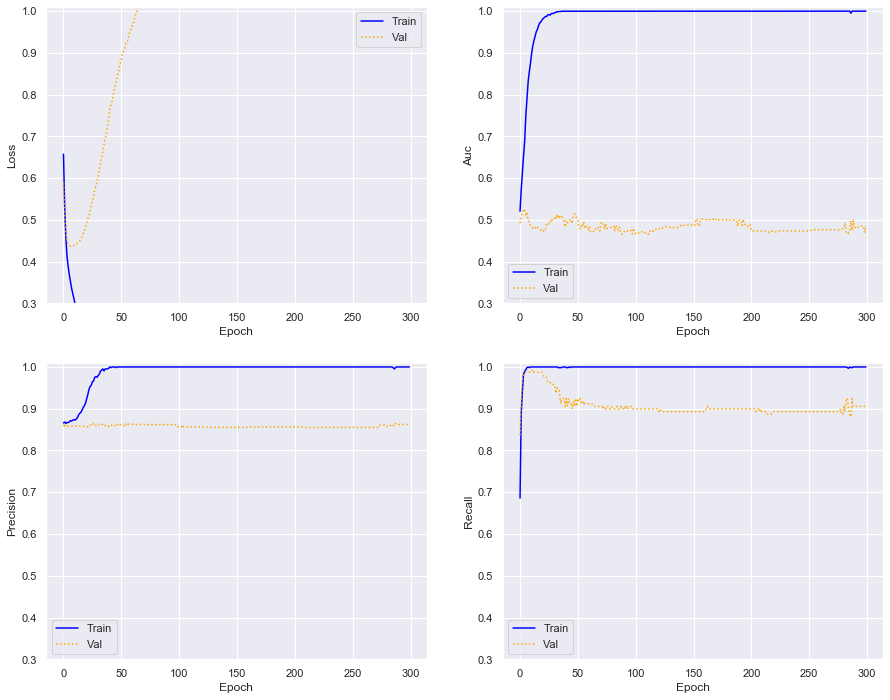

In [53]:
print('training took: ', stop - start)
print(model.summary())

plot_metrics(history)

**Evaluate the model**

We the confussion matriz, se the ROC curve and finally we take a look at the good clients to see how the model performs

In [54]:
train_results_baseline, test_results_baseline = keras_model_evaluation(model, Tensor_train, 
                                                                       y_train, Tensor_test, y_test,BATCH_SIZE)
train_results_baseline.columns

Accuracy: 0.7945946
Area Under Curve: 0.48584908



Index(['true_label', 'predicted_proba', 'predicted_label'], dtype='object')

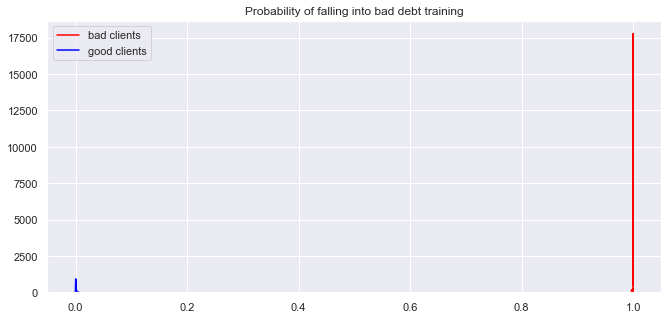

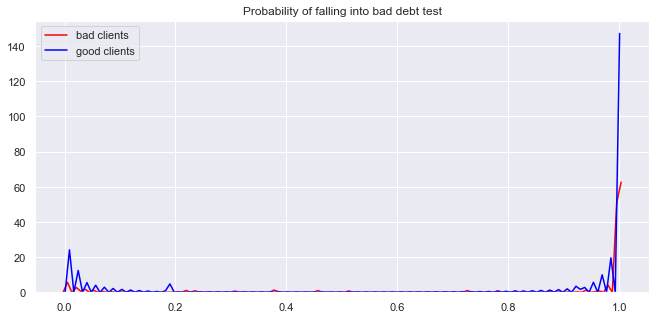

In [55]:
# plot the probability distributions in training and test
current_df = train_results_baseline
plt.figure(figsize=(11,5))
plt.title('Probability of falling into bad debt training')
sns.kdeplot(current_df[current_df.true_label==1]['predicted_proba'],color='red' ,label='bad clients')
sns.kdeplot(current_df[current_df.true_label==0]['predicted_proba'],color='blue' ,label='good clients')

current_df = test_results_baseline

plt.figure(figsize=(11,5))
plt.title('Probability of falling into bad debt test')
sns.kdeplot(current_df[current_df.true_label==1]['predicted_proba'],color='red' ,label='bad clients')
sns.kdeplot(current_df[current_df.true_label==0]['predicted_proba'],color='blue' ,label='good clients')


Train confussion matrix: 
[[106   0]
 [  0 631]]
test confussion matrix: 
[[  3  23]
 [ 15 144]]
ROC z=15


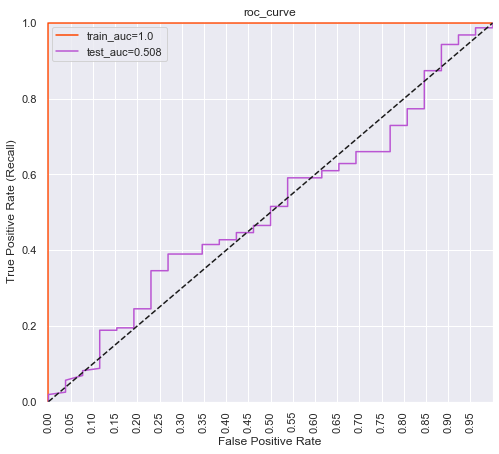

In [56]:
print('Train confussion matrix: ')
print(confusion_matrix(train_results_baseline['true_label'], train_results_baseline['predicted_label']))
print('test confussion matrix: ')
print(confusion_matrix(test_results_baseline['true_label'], test_results_baseline['predicted_label']))

print('ROC z=15')    
plot_roc_curve(train_results_baseline['true_label'], train_results_baseline['predicted_proba'],
               test_results_baseline['true_label'], test_results_baseline['predicted_proba'])


# Optimization
# IT MAY BE FASTER TO USE GRID SEARCH TO TUNE THESE PARAMETERS

we try to uprade the model by tuning the hyper parameters and architecture

1. increase num of neurons: for 1 hidden layer 10 neurons gives the best performance
2. increase num of layers
3. tune droput
4. regularization
5. Tune learning rate
6. tune batch size
7. use sample weights


First we optimize one layer for several values of learning rates, different regularization and batches. In all of these we vary the number of neurons a bit also

### Learning Rate

In [24]:
rate_metrics_dict = {'first_layer_neurons':[], 'learning_rate':[], 'train_auc':[], 'test_auc':[], 
                     'test_tnr':[],'test_fnr':[], 'regularization':[], 'history':[]}

# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 1
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]

# name of the files to save
weights_name = 'weights_lstm_optimized.h5'

USE_DROPOUT = True
BATCH_NORM = False
# hyper params
first_layer_sizes = [100]
LEARNING_RATES = [0.0001,0.001,0.01,0.1]
REGULARIZATIONS = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]

#scores = model.evaluate(Tensor_test, np.asarray(y_test), verbose=0)
#val_tnr = 3, val_fnr = 4

In [25]:
for h1 in first_layer_sizes:
    for lr in LEARNING_RATES:
        for REG in REGULARIZATIONS:
            print()
            print('init')
            print(REG.get_config())
            HIDDEN_LAYER_SIZES = [h1]
            # compile the model 
            tf.keras.backend.clear_session()
            init_random(1234)
            # build the model
            model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, BATCH_NORM ,lr, REG,
                               weights_name, TIME_STEPS, FEATURES)
            # train the model
            start = timeit.default_timer()
            history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping], verbose = 0)
            stop = timeit.default_timer()

            scores = model.evaluate(Tensor_train, np.asarray(y_train), verbose=0)
            print("train Accuracy:", scores[5] )
            print("train Area Under Curve:", scores[8] )

            rate_metrics_dict['train_auc'].append(scores[8])

            scores = model.evaluate(Tensor_test, np.asarray(y_test), verbose=0)
            print("test Accuracy:", scores[5] )
            print("test Area Under Curve:", scores[8] )
            rate_metrics_dict['test_auc'].append(scores[8])
            rate_metrics_dict['test_tnr'].append(scores[3])
            rate_metrics_dict['test_fnr'].append(scores[4])

            # append parameters
            rate_metrics_dict['first_layer_neurons'].append(h1)
            rate_metrics_dict['learning_rate'].append(lr)
            rate_metrics_dict['regularization'].append(REG.get_config())
            rate_metrics_dict['history'].append(history)



init
{'l1': 0.0, 'l2': 0.0}
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
train Accuracy: 0.6227951
train Area Under Curve: 0.4761086
test Accuracy: 0.61621624
test Area Under Curve: 0.4534349

init
{'l1': 0.009999999776482582, 'l2': 0.0}
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
train Accuracy: 0.5766621
train Area Under Curve: 0.46141195
test Accuracy: 0.55135137
test Area Under Curve: 0.44593614

init
{'l1': 0.0, 'l2': 0.009999999776482582}
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
train Accuracy: 0.60786974
train Area Under Curve: 0.47287923
test Accuracy: 0.6
test Area Under Curve: 0.45706338

init
{'l1': 0.009999999776482582, 'l2': 0.009999999776482582}
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
train Accuracy: 0.5753053
train Area Under Curve: 0.46126246
test Accuracy: 0.55135137
test Area Under Curve: 0.44593614

ini

In [40]:
#joblib.dump(rate_metrics_dict, 'rate_metrics_dict_100.p') 
#history_list = [rate_metrics_dict['history'][i].history for i in range (0, len(rate_metrics_dict['history']))]
rate_metrics_dict['history_list'] = history_list
joblib.dump(rate_metrics_dict, 'rate_metrics_dict_100.p') 


['rate_metrics_dict_100.p']

In [41]:
optimizer_metrics = joblib.load('rate_metrics_dict_100.p') 
print(optimizer_metrics.keys())
pd_metrics = pd.DataFrame.from_dict(optimizer_metrics)
# get the interesting metrics
pd_metrics = pd_metrics[pd_metrics['test_tnr']>0]

dict_keys(['first_layer_neurons', 'learning_rate', 'train_auc', 'test_auc', 'test_tnr', 'test_fnr', 'regularization', 'history_list'])


In [42]:
pd_metrics[pd_metrics['test_fnr']==pd_metrics['test_fnr'].min()]

,first_layer_neurons,learning_rate,train_auc,test_auc,test_tnr,test_fnr,regularization,history_list
5,100,0.001,0.546206,0.476415,1.0,5.0,"{'l1': 0.009999999776482582, 'l2': 0.0}","{'loss': [28.755253586063876, 18.3521045079224..."
7,100,0.001,0.544553,0.476657,1.0,5.0,"{'l1': 0.009999999776482582, 'l2': 0.009999999...","{'loss': [30.87544112548414, 19.44197125997763..."


In [43]:
pd_metrics[(pd_metrics['train_auc']>0.5) & (pd_metrics['test_auc']>0.5)].sort_values(by='test_auc',ascending=False)

,first_layer_neurons,learning_rate,train_auc,test_auc,test_tnr,test_fnr,regularization,history_list
8,100,0.010,1.000000,0.55999,4.0,8.0,"{'l1': 0.0, 'l2': 0.0}","{'loss': [0.517947541264213, 0.251028442843798..."
4,100,0.001,0.999208,0.53193,5.0,30.0,"{'l1': 0.0, 'l2': 0.0}","{'loss': [0.5890502445248121, 0.40183012009556..."


### class weights and batch norms

we take the "best" of the previous analysis and then use a class weight to punish erros in the minority class. First we get the count of each class in the training set.

Also try with batch normalization.

In [45]:
# first, calculate the class weights
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 3.48
Weight for class 1: 0.58


In [55]:
# define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)


In [62]:
# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 1
HIDDEN_LAYER_SIZES = [15]
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]
# no reg
REG = L1L2(l1=0.01, l2=0.0)

USE_DROPOUT = True
BATCH_NORM = False
LEARNING_RATE = 0.0005

# name of the files to save
weights_name = 'weights_lstm.h5'

# compile the model 
tf.keras.backend.clear_session()
init_random(1234)

# build the model
model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, BATCH_NORM, LEARNING_RATE, REG,
                   weights_name, TIME_STEPS, FEATURES)



In [63]:
# train ,class_weight=class_weight
print('time start')
start = timeit.default_timer()

history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping], class_weight=class_weight)

stop = timeit.default_timer()


time start
Train on 737 samples, validate on 185 samples
Epoch 1/300
737/737 [==============================] - 19s 26ms/sample - loss: 8.8353 - tp: 342.0000 - fp: 49.0000 - tn: 57.0000 - fn: 289.0000 - accuracy: 0.5414 - precision: 0.8747 - recall: 0.5420 - auc: 0.5202 - val_loss: 8.3601 - val_tp: 99.0000 - val_fp: 16.0000 - val_tn: 10.0000 - val_fn: 60.0000 - val_accuracy: 0.5892 - val_precision: 0.8609 - val_recall: 0.6226 - val_auc: 0.5024
Epoch 2/300
737/737 [==============================] - 1s 2ms/sample - loss: 8.0064 - tp: 374.0000 - fp: 53.0000 - tn: 53.0000 - fn: 257.0000 - accuracy: 0.5794 - precision: 0.8759 - recall: 0.5927 - auc: 0.5657 - val_loss: 7.5877 - val_tp: 98.0000 - val_fp: 16.0000 - val_tn: 10.0000 - val_fn: 61.0000 - val_accuracy: 0.5838 - val_precision: 0.8596 - val_recall: 0.6164 - val_auc: 0.4886
Epoch 3/300
737/737 [==============================] - 1s 1ms/sample - loss: 7.2508 - tp: 352.0000 - fp: 53.0000 - tn: 53.0000 - fn: 279.0000 - accuracy: 0.5495 - 

Epoch 22/300
737/737 [==============================] - 1s 1ms/sample - loss: 1.0155 - tp: 471.0000 - fp: 50.0000 - tn: 56.0000 - fn: 160.0000 - accuracy: 0.7151 - precision: 0.9040 - recall: 0.7464 - auc: 0.7274 - val_loss: 1.0505 - val_tp: 126.0000 - val_fp: 20.0000 - val_tn: 6.0000 - val_fn: 33.0000 - val_accuracy: 0.7135 - val_precision: 0.8630 - val_recall: 0.7925 - val_auc: 0.5079
Epoch 23/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.9749 - tp: 504.0000 - fp: 53.0000 - tn: 53.0000 - fn: 127.0000 - accuracy: 0.7558 - precision: 0.9048 - recall: 0.7987 - auc: 0.7235 - val_loss: 1.0136 - val_tp: 124.0000 - val_fp: 20.0000 - val_tn: 6.0000 - val_fn: 35.0000 - val_accuracy: 0.7027 - val_precision: 0.8611 - val_recall: 0.7799 - val_auc: 0.5096
Epoch 24/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.9385 - tp: 506.0000 - fp: 50.0000 - tn: 56.0000 - fn: 125.0000 - accuracy: 0.7626 - precision: 0.9101 - recall: 0.8019 - auc: 0.7551 - val_l

Epoch 43/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.7282 - tp: 504.0000 - fp: 45.0000 - tn: 61.0000 - fn: 127.0000 - accuracy: 0.7666 - precision: 0.9180 - recall: 0.7987 - auc: 0.7514 - val_loss: 0.7650 - val_tp: 127.0000 - val_fp: 17.0000 - val_tn: 9.0000 - val_fn: 32.0000 - val_accuracy: 0.7351 - val_precision: 0.8819 - val_recall: 0.7987 - val_auc: 0.5352
Epoch 44/300
737/737 [==============================] - 1s 1ms/sample - loss: 0.7257 - tp: 513.0000 - fp: 53.0000 - tn: 53.0000 - fn: 118.0000 - accuracy: 0.7680 - precision: 0.9064 - recall: 0.8130 - auc: 0.7478 - val_loss: 0.7612 - val_tp: 124.0000 - val_fp: 17.0000 - val_tn: 9.0000 - val_fn: 35.0000 - val_accuracy: 0.7189 - val_precision: 0.8794 - val_recall: 0.7799 - val_auc: 0.5425
Epoch 45/300
737/737 [==============================] - 1s 2ms/sample - loss: 0.7221 - tp: 502.0000 - fp: 47.0000 - tn: 59.0000 - fn: 129.0000 - accuracy: 0.7612 - precision: 0.9144 - recall: 0.7956 - auc: 0.7483 - val_l

training took:  67.71727518100033
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  9630      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  31        
Total params: 9,661
Trainable params: 9,661
Non-trainable params: 0
_________________________________________________________________
None


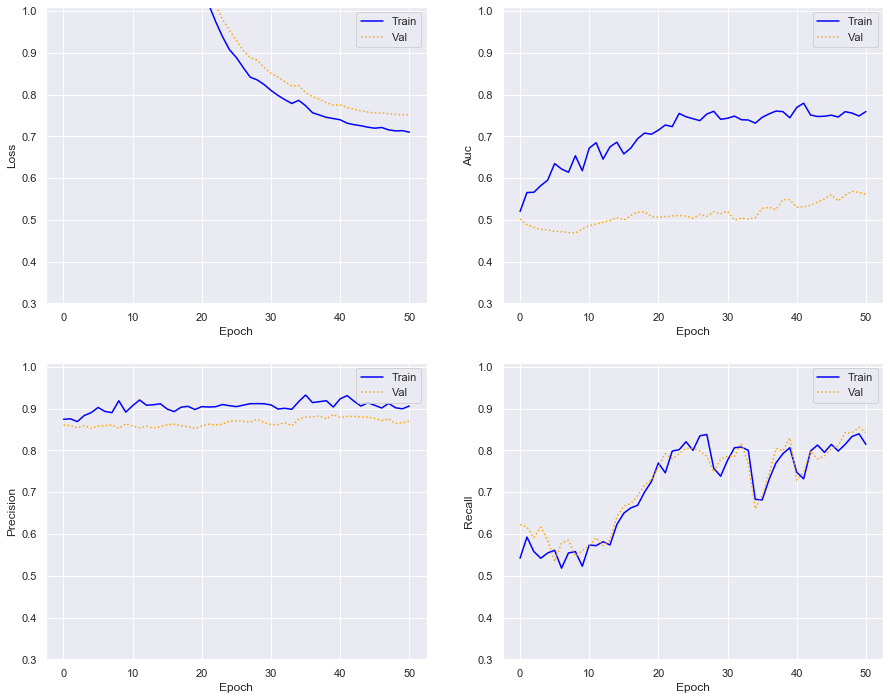

In [64]:
print('training took: ', stop - start)
print(model.summary())

plot_metrics(history)

In [65]:
train_results_baseline, test_results_baseline = keras_model_evaluation(model, Tensor_train, 
                                                                       y_train, Tensor_test, y_test,BATCH_SIZE)
train_results_baseline.columns

Accuracy: 0.5891892
Area Under Curve: 0.502419



Index(['true_label', 'predicted_proba', 'predicted_label'], dtype='object')

Train confussion matrix: 
[[ 49  57]
 [263 368]]
test confussion matrix: 
[[10 16]
 [60 99]]
ROC z=15


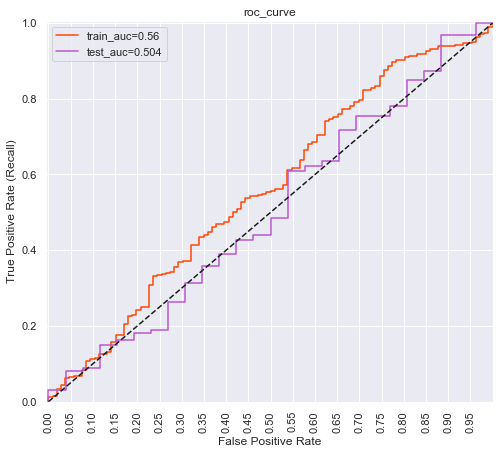

In [66]:
print('Train confussion matrix: ')
print(confusion_matrix(train_results_baseline['true_label'], train_results_baseline['predicted_label']))
print('test confussion matrix: ')
print(confusion_matrix(test_results_baseline['true_label'], test_results_baseline['predicted_label']))

print('ROC z=15')    
plot_roc_curve(train_results_baseline['true_label'], train_results_baseline['predicted_proba'],
               test_results_baseline['true_label'], test_results_baseline['predicted_proba'])

### Batch size

# Adding hidden layers

First, try 2 hidden layers of LSTM'S find best configuration of neurons. Then, try adding 1 dense layer on top of the recursive one. 


### extra LSTM layer

In [26]:
# define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)

In [27]:
metrics_dict = {'first_layer_neurons':[], 'second_layer_neurons':[], 'train_auc':[], 'test_auc':[], 
                     'test_tnr':[],'test_fnr':[], 'history':[]}

In [28]:
# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 2
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]
REG = L1L2(l1=0.0, l2=0.0)

USE_DROPOUT = True
BATCH_NORM = False
LEARNING_RATE = 0.0005
# name of the files to save
weights_name = 'weights_lstm_optimized.h5'

# for each size of first layer, iterate over all the seond layer sizes
first_layer_sizes = [2,10,20,50]
second_layer_sizes = [2,10,20,50]

for h1 in first_layer_sizes:
    for h2 in second_layer_sizes:
        print('init')
        HIDDEN_LAYER_SIZES = [h1, h2]
        # compile the model 
        tf.keras.backend.clear_session()
        init_random(1234)
        # build the model
        model = build_lstm(EPOCHS, BATCH_SIZE, HIDDEN_LAYER_SIZES, NUM_LAYERS, USE_DROPOUT, BATCH_NORM ,LEARNING_RATE, REG,
                           weights_name, TIME_STEPS, FEATURES)
        # train the model
        start = timeit.default_timer()
        history = model.fit(Tensor_train, np.asarray(y_train), validation_data=(Tensor_test, np.asarray(y_test)),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping],verbose = 0)
        stop = timeit.default_timer()
        
        scores = model.evaluate(Tensor_train, np.asarray(y_train), verbose=0)
        print("train Accuracy:", scores[5] )
        print("train Area Under Curve:", scores[8] )
        
        metrics_dict['train_auc'].append(scores[8])
        
        scores = model.evaluate(Tensor_test, np.asarray(y_test), verbose=0)
        print("test Accuracy:", scores[5] )
        print("test Area Under Curve:", scores[8] )
        
        metrics_dict['test_auc'].append(scores[8])   
        metrics_dict['test_tnr'].append(scores[3])
        metrics_dict['test_fnr'].append(scores[4])
            
        # append neurons
        metrics_dict['first_layer_neurons'].append(h1)
        metrics_dict['second_layer_neurons'].append(h2)
        metrics_dict['history'].append(history.history)
             


init
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
train Accuracy: 0.6119403
train Area Under Curve: 0.46391624
test Accuracy: 0.61621624
test Area Under Curve: 0.4669811
init
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
train Accuracy: 0.73948437
train Area Under Curve: 0.46815473
test Accuracy: 0.7297297
test Area Under Curve: 0.5232221
init
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
train Accuracy: 0.7503392
train Area Under Curve: 0.47490507
test Accuracy: 0.7675676
test Area Under Curve: 0.54704887
init
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
train Accuracy: 0.85345995
train Area Under Curve: 0.46115035
test Accuracy: 0.85945946
test Area Under Curve: 0.4358974
init
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
train Accuracy: 0.6621438
train Area Under Curve: 0.5589735
test Accuracy:

In [32]:
#joblib.dump(metrics_dict, 'rate_metrics_dict_2_lstm.p') 


['rate_metrics_dict_2_lstm.p']

In [102]:
optimizer_metrics = joblib.load('rate_metrics_dict_2_lstm.p') 
print(optimizer_metrics.keys())
pd_metrics = pd.DataFrame.from_dict(optimizer_metrics)
# get the interesting metrics
pd_metrics = pd_metrics[(pd_metrics['train_auc']<1.0) & (pd_metrics['test_tnr']>0)]

dict_keys(['first_layer_neurons', 'second_layer_neurons', 'train_auc', 'test_auc', 'test_tnr', 'test_fnr', 'history'])


In [103]:
pd_metrics.sort_values(by='test_auc', ascending=False)


,first_layer_neurons,second_layer_neurons,train_auc,test_auc,test_tnr,test_fnr,history
2,2,20,0.474905,0.547049,3.0,20.0,"{'loss': [0.6822696449475179, 0.65434218148525..."
9,20,10,0.521978,0.541485,8.0,33.0,"{'loss': [0.6895324494007323, 0.65085862813519..."
1,2,10,0.468155,0.523222,6.0,30.0,"{'loss': [0.6864906111921676, 0.67479394871635..."
8,20,2,0.508223,0.506047,5.0,23.0,"{'loss': [0.6719216317787584, 0.63151714937657..."
4,10,2,0.558973,0.493469,8.0,42.0,"{'loss': [0.6945821041976742, 0.66388475886840..."
6,10,20,0.539253,0.481132,5.0,24.0,"{'loss': [0.6694069753831892, 0.62413286103322..."
0,2,2,0.463916,0.466981,9.0,54.0,"{'loss': [0.6944065189426272, 0.67438347077596..."
12,50,2,0.578380,0.451258,3.0,10.0,"{'loss': [0.662767042217617, 0.607018051267155..."
5,10,10,0.560454,0.442308,2.0,25.0,"{'loss': [0.6873459507846444, 0.66105104616894..."


Plot the training history of losss and auc for each architecture

In [104]:
number_of_colors = 17
color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 
                 for i in range(number_of_colors)]


(0, 1.05)

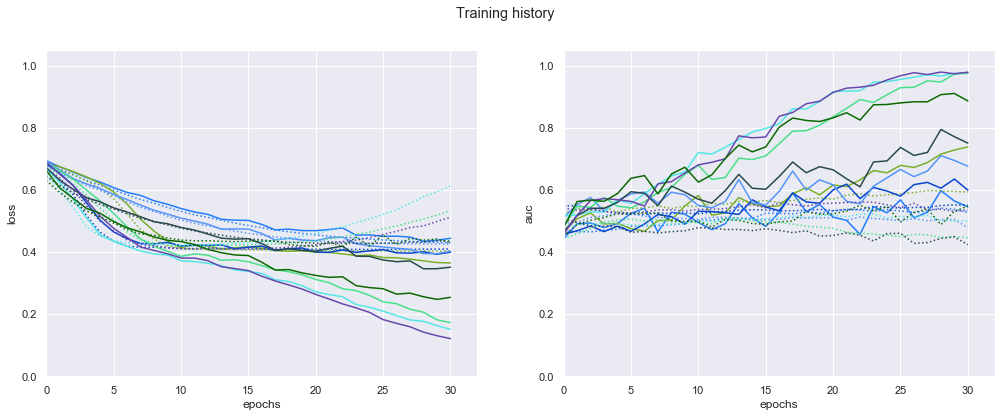

In [122]:
plt.figure(figsize=(17,6))
plt.suptitle('Training history')
i = 0
# plot all of the losses
plt.subplot(1,2,1)
for i in range(0,len(pd_metrics)):
    history_dict = pd_metrics.iloc[i]['history']
    x = np.arange(0,len(history_dict['loss']))

    plt.plot(x, history_dict['loss'],color=color_list[i])
    plt.plot(x, history_dict['val_loss'], linestyle=':',color=color_list[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0,32)
plt.ylim(0,1.05)

#plot all of the auc's
plt.subplot(1,2,2)
for i in range(0,len(pd_metrics)):
    history_dict = pd_metrics.iloc[i]['history']
    x = np.arange(0,len(history_dict['auc']))
    plt.plot(x, history_dict['auc'],color=color_list[i])
    plt.plot(x, history_dict['val_auc'], linestyle=':',color=color_list[i])

plt.xlabel('epochs')
plt.ylabel('auc')
plt.xlim(0,32)
plt.ylim(0,1.05)


### Intentemos con una arcitectura 10 a 10

In [161]:
# define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=40,
    mode='max',
    restore_best_weights=True)

# DEFINING THE BASIC FORM OF THE NN
EPOCHS = 300
BATCH_SIZE = 32
NUM_LAYERS = 2
HIDDEN_LAYER_SIZES = [10,10]
TIME_STEPS = Tensor_train.shape[2]
FEATURES = Tensor_train.shape[1]

# regularization
REG = L1L2(l1=0.01, l2=0.0)

USE_DROPOUT = True
BATCH_NORM = False

# name of the files to save
WEIGHTS_NAME = 'weights_lstm_2_layers.h5'

# compile the model 
tf.keras.backend.clear_session()
init_random(1234)

# build the model in a keras wrapper to gridsearch faster
model = KerasClassifier(build_fn=build_lstm)

param_grid=dict(
    epochs = [EPOCHS], 
    batch_size=[BATCH_SIZE], 
    hidden_layer_size=[HIDDEN_LAYER_SIZES], 
    num_layers=[NUM_LAYERS], 
    use_dropout=[USE_DROPOUT], 
    use_batch_norm=[BATCH_NORM] ,
    learnin_rate=[0.0005,0.005,0.05], 
    reg=[REG],
    weights_name=[WEIGHTS_NAME], 
    time_steps=[TIME_STEPS], 
    features=[FEATURES])

In [ ]:
start = timeit.default_timer()

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(Tensor_train, np.asarray(y_train))

stop = timeit.default_timer()



In [ ]:
print('training took: ', stop - start)
print(grid.summary())

#plot_metrics(history)